In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 50, 50  # that's default image size for this interactive session
from PIL import Image
import pytesseract
import argparse
import imutils
import random
import os

# Basic Motion Detection

 there are many, many ways to perform motion detection, tracking, and analysis in OpenCV. Some are very simple. And others are very complicated. The two primary methods are forms of Gaussian Mixture Model-based foreground and background segmentation:

    An improved adaptive background mixture model for real-time tracking with shadow detection by KaewTraKulPong et al., available through the cv2.BackgroundSubtractorMOG  function.
    Improved adaptive Gaussian mixture model for background subtraction by Zivkovic, and Efficient Adaptive Density Estimation per Image Pixel for the Task of Background Subtraction, also by Zivkovic, available through the cv2.BackgroundSubtractorMOG2  function.

And in newer versions of OpenCV we have Bayesian (probability) based foreground and background segmentation, implemented from Godbehere et al.’s 2012 paper, Visual Tracking of Human Visitors under Variable-Lighting Conditions for a Responsive Audio Art Installation. We can find this implementation in the cv2.createBackgroundSubtractorGMG  function (we’ll be waiting for OpenCV 3 to fully play with this function though).

All of these methods are concerned with segmenting the background from the foreground (and they even provide mechanisms for us to discern between actual motion and just shadowing and small lighting changes)!

Well, in motion detection, we tend to make the following assumption:

The background of our video stream is largely static and unchanging over consecutive frames of a video. Therefore, if we can model the background, we monitor it for substantial changes. If there is a substantial change, we can detect it — this change normally corresponds to motion on our video.

The methods I mentioned above, while very powerful, are also computationally expensive. And since our end goal is to deploy this system to a Raspberry Pi at the end of this 2 part series, it’s best that we stick to simple approaches. We’ll return to these more powerful methods in future blog posts, but for the time being we are going to keep it simple and efficient.

In [31]:
# Initialize the first frame
firstFrame = None
# Open video
cap = cv2.VideoCapture('matricula1.mp4')
# Initialize array of images which will have the cropped pics
cropped_imgs = []

Assumption: The first frame of our video file will contain no motion and just background — therefore, we can model the background of our video stream using only the first frame of the video.

In [32]:
#width to reescale image to
width_res = 1000
while(cap.isOpened()):
    ret, frame = cap.read()
    
    
    if cv2.waitKey(10) & 0xFF == ord('q') or not ret:
        break

    else:
        # convert image to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # If required, initialize firstFrame (first iteration)
        if firstFrame is None:
            # create mask for image. Only required in first iteration
            mask = np.ones(gray.shape[:2], np.uint8)*255

            h = 0
            for j in range(0,700):
                for i in range(0,1000-int(h*1.43)):
                    mask[j][i] = 0
                h = h+1
            h = 0    
            for j in range(0,720):
                for i in range(1280-int(h*0.5),1280):
                    mask[j][i] = 0
                h=h+1
    
            mask[670:720, :] = 0

            # Apply mask
            masked_img = cv2.bitwise_and(gray,gray,mask = mask)
        
            # resize frame
            resized = imutils.resize(masked_img, width=width_res)
        
            # apply Gaussian blur
            gauss = cv2.GaussianBlur(resized, (41, 41), 0)
            firstFrame = gauss
            continue
            
        # Apply mask
        masked_img = cv2.bitwise_and(gray,gray,mask = mask)
        
        # resize frame
        resized = imutils.resize(masked_img, width=width_res)
        
        # apply Gaussian blur
        gauss = cv2.GaussianBlur(resized, (41, 41), 0)
        
        # compute the absolute difference between the current frame and
        # first frame
        frameDelta = cv2.absdiff(firstFrame, gauss)
        thresh_diff = cv2.threshold(frameDelta, 25, 255, cv2.THRESH_BINARY)[1]
        
        # dilate the thresholded image to fill in holes, then find contours
        # on thresholded image
        thresh_diff = cv2.dilate(thresh_diff, None, iterations=2)
        (_,cnts, _) = cv2.findContours(thresh_diff.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
        
        # order the contours from big to smaller
        cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:2]
        
        contour_area_prev = None
        
        # loop over the contours
        for c in cnts:
            # Obtain difference between previous and current area of contour
            contour_area = cv2.contourArea(c)
            # First iteration
            if contour_area_prev == None:
                contour_area_prev = cv2.contourArea(c)
                
            diff_areas = contour_area - contour_area_prev            
            contour_area_prev = contour_area
            
            # if the contour is too small,or similar size to previous contour, ignore it
            if contour_area < 1000 :
                continue
            # compute the bounding box for the contour, draw it on the frame,
            # and update the text
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(gauss, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # Crop the image inside the contour. Doing it to image without gauss
            # because otherwise the plate is not visible!!
            crop_img = resized[y:y+h, x:x+w]
            cropped_imgs.append(crop_img)
            cv2.imshow("cropped", crop_img)
            

        # show gray frame
        cv2.imshow('frame', gauss)
        
cap.release()
cv2.destroyAllWindows()

# Lookup Table

Create the Lut table as y = x³/255²

In [33]:
lut = np.zeros(256,np.uint8)
for i in range(0,256):
    lut[i] = (i**3)/(255**2)

Modify masked image with the Lookup table

In [34]:
lut_img_array = []
for pic in cropped_imgs:
    lut_img = pic.copy()
    cv2.LUT(pic,lut,lut_img)
    lut_img_array.append(lut_img)

## Blurring

This is done by convolving image with a normalized box filter. It simply takes the average of all the pixels under kernel area and replace the central element. This is done by the function cv2.blur() or cv2.boxFilter(). Check the docs for more details about the kernel. We should specify the width and height of kernel. A 3x3 normalized box filter would look like below:

In [35]:
blur_avg_array = []
blur_gauss_array = []

for lut in lut_img_array:
    blur_avg = cv2.blur(lut,(2,2))
    blur_avg_array.append(blur_avg)
    blur_gauss = cv2.GaussianBlur(lut,(3,3),20,20)
    blur_gauss_array.append(blur_gauss)


### Let's print an example!

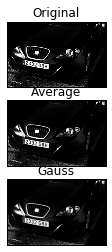

In [37]:
rdn = random.randrange(0, len(blur_avg_array), 1)        

plt.subplot(311),plt.imshow(lut_img_array[rdn], 'gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])

plt.subplot(312),plt.imshow(blur_avg_array[rdn], 'gray'),plt.title('Average')
plt.xticks([]), plt.yticks([])

plt.subplot(313),plt.imshow(blur_gauss_array[rdn], 'gray'),plt.title('Gauss')
plt.xticks([]), plt.yticks([])

plt.show()

# Threshold

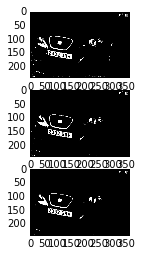

In [38]:
thresh_array = []
threshavg_array = []
thresgauss_array = []

for i in range (len(lut_img_array)):
    ret,thresh = cv2.threshold(lut_img_array[i],150,255,cv2.THRESH_BINARY)
    thresh_array.append(thresh)
    ret,threshavg = cv2.threshold(blur_avg_array[i],150,255,cv2.THRESH_BINARY)
    threshavg_array.append(threshavg)
    ret,thresgauss = cv2.threshold(blur_gauss_array[i],150,255,cv2.THRESH_BINARY)
    thresgauss_array.append(thresgauss)

plt.subplot(311),plt.imshow(thresh_array[rdn], cmap='gray')

plt.subplot(312),plt.imshow(threshavg_array[rdn], cmap='gray')

plt.subplot(313),plt.imshow(thresgauss_array[rdn], cmap='gray')
plt.show()

# Erosion

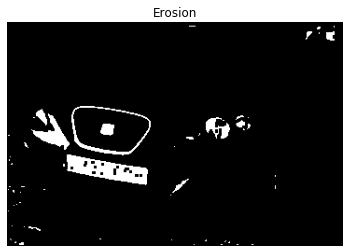

In [39]:
kernel = np.ones((3,3),np.uint8)

opening_array = []

for th in threshavg_array:
    opening = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)
    #opening = cv2.dilate(threshavg, kernel,1)
    opening_array.append(opening)

plt.imshow(opening_array[rdn], 'gray'),plt.title('Erosion')
plt.xticks([]), plt.yticks([])
plt.show()

# Find rectangle in the image

## Find contours

 Python: cv2.findContours(image, mode, method[, contours[, hierarchy[, offset]]]) → contours, hierarchy
 
 mode: CV_RETR_EXTERNAL retrieves only the extreme outer contours. It sets hierarchy[i][2]=hierarchy[i][3]=-1 for all the contours. Porque no nos interesa lo que hay dentro de los rectángulos, solo el rectángulo en sí
 
 method: CV_CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments and leaves only their end points. For example, an up-right rectangular contour is encoded with 4 points. Porque más adelante necesitaremos proporcionar a las funciones un array de puntos, no líneas
 
 sorting our contours, from largest to smallest, by calculating the area of the contour using cv2.contourArea. We now have only the 10 largest contours. 

In [40]:
cnts_array = []
cnts_avg_array = []
cnts_opening_array = []
cnts_gauss_array = []

for i in range (len(lut_img_array)):
    _, contours, _= cv2.findContours(thresh_array[i].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
    cnts_array.append(cnts)
    
    _, contours_avg, _= cv2.findContours(threshavg_array[i].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts_avg = sorted(contours_avg, key = cv2.contourArea, reverse = True)[:10]
    cnts_avg_array.append(cnts_avg)
    
    _, contours_opening, _= cv2.findContours(opening_array[i].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts_opening = sorted(contours_opening, key = cv2.contourArea, reverse = True)[:10]
    cnts_opening_array.append(cnts_opening)
    
    _, contours_gauss, _= cv2.findContours(thresgauss_array[i].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts_gauss = sorted(contours_gauss, key = cv2.contourArea, reverse = True)[:10]
    cnts_gauss_array.append(cnts_gauss)
    


## Find rotated rectangle

Here, bounding rectangle is drawn with minimum area, so it considers the rotation also. The function used is cv2.minAreaRect(). It returns a Box2D structure which contains following detals - ( center (x,y), (width, height), angle of rotation ). But to draw this rectangle, we need 4 corners of the rectangle. It is obtained by the function cv2.boxPoints()

With avg

## Lut image

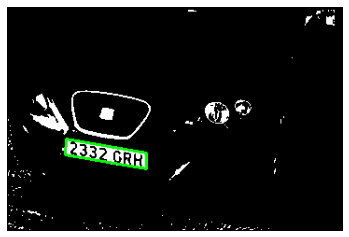

In [41]:
rect = []
frame_aux_array = []

for i in range(len(thresh_array)):
    frame_aux = cv2.cvtColor(thresh_array[i].copy(),cv2.COLOR_GRAY2RGB)
    for cont in cnts_array[i]:
        # approximate the contour
        peri = cv2.arcLength(cont, True)
        approx = cv2.approxPolyDP(cont, 0.02 * peri, True)

        # if our approximated contour has four points, then
        # we can assume that we have found our screen
        if len(approx) == 4:
            cv2.drawContours(frame_aux,[approx],0,(0,255,0),2)
    frame_aux_array.append(frame_aux)

plt.imshow(frame_aux_array[rdn])
plt.xticks([]), plt.yticks([])
plt.show()

### Gauss

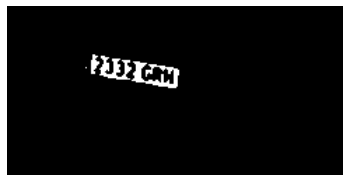

In [13]:
frame_aux_array = []

for i in range(len(thresgauss_array)):
    frame_aux = cv2.cvtColor(thresgauss_array[i].copy(),cv2.COLOR_GRAY2RGB)
    for cont in cnts_gauss_array[i]:
        # approximate the contour
        peri = cv2.arcLength(cont, True)
        approx = cv2.approxPolyDP(cont, 0.02 * peri, True)

        # if our approximated contour has four points, then
        # we can assume that we have found our screen
        if len(approx) == 4:
            cv2.drawContours(frame_aux,[approx],0,(0,255,0),2)
    frame_aux_array.append(frame_aux)

plt.imshow(frame_aux_array[rdn])
plt.xticks([]), plt.yticks([])
plt.show()

### Average

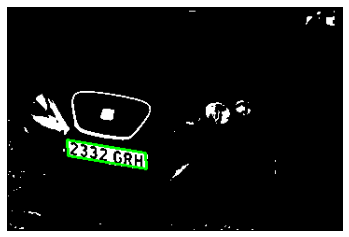

In [52]:
frame_aux_array = []

for i in range(len(threshavg_array)):
    frame_aux = cv2.cvtColor(threshavg_array[i].copy(),cv2.COLOR_GRAY2RGB)
    for cont in cnts_avg_array[i]:
        # approximate the contour
        peri = cv2.arcLength(cont, True)
        approx = cv2.approxPolyDP(cont, 0.02 * peri, True)

        # if our approximated contour has four points, then
        # we can assume that we have found our screen
        if len(approx) == 4:
            cv2.drawContours(frame_aux,[approx],0,(0,255,0),2)
    frame_aux_array.append(frame_aux)

plt.imshow(frame_aux_array[rdn])
plt.xticks([]), plt.yticks([])
plt.show()

### Check all contours and find the rectangle with the License Plate

470
470


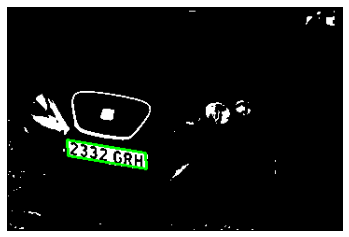

In [43]:
# En esta variable almacenaremos el array con todos los contornos de todos los rectangulos. Los almacena en orden
# luego hay que cogerlos de 4 en 4. En esta variable aun no valoramos si los rectangulos
# tienen los lados iguales dos a dos.
contornos_varios = []
# En esta variable almacenamos los contornos que mejor se ajustan a una forma de rectángulo
# para cada imagen
best_rect_array = []
# Lo voy a necesitar mas tarde para la homografia
best_widthA_array = []
best_widthB_array = []
best_heightA_array = []
best_heightB_array = []
# esta variable ya esta creada, creo. comprobar despues si puedo borrar esta linea
#frame_aux_array = cv2.cvtColor(thresgauss_array.copy(),cv2.COLOR_GRAY2RGB)
rect = []

n = 0

for i in range(len(frame_aux_array)):
    # Solo necesitamos la variable dentro del bucle, luego la inicializamos cada vez que 
    # entramos.
    contornos_varios = []
    for cont in cnts_avg_array[i]:
        # approximate the contour
        peri = cv2.arcLength(cont, True)
        approx = cv2.approxPolyDP(cont, 0.02 * peri, True)

        # if our approximated contour has four points, then
        # we can assume that we have found our plate
        if len(approx) == 4:
            cv2.drawContours(frame_aux_array[i],[approx],0,(0,255,0),2)
            screenCnt = approx 
            contornos_varios.append(screenCnt)
        # Si no se detectan rectángulos, la variable contornos varios se queda vacia
        # y necesitamos tener tantos contornos como imagenes. Luego si no se detecta contorno, cogemos
        # la imagen entera
        
    
    if len(contornos_varios) == 0:

        height, width, channels = frame_aux_array[i].shape
        contornos_varios = [np.array([[0,  0],[width,  0],[width,  height],[0,  height]])]


    # Sometimes more than one rectangle appears. Let's check that it's rectangle shaped
    init = True
    best_widthA = 0
    best_widthB = 0
    best_heightA = 0
    best_heightB = 0
    

    
    for c in contornos_varios:

        corners = c.reshape(4, 2)
        rect = np.zeros((4, 2), dtype = "float32")
        # Aquí vamos a comprobar el orden de los puntos. Lo vamos a necesitar ahora para 
        # comparar los lados dos a dos, y despues para hacer la homografía.
        # Almacenamos los puntos en orden en la variable rect.
        s = corners.sum(axis = 1)
        #Top-left has the minimum sum
        #Bottom-right has maximum sum
        rect[0] = corners[np.argmin(s)]
        rect[2] = corners[np.argmax(s)]
        #Top-right has the minimum difference
        #Bottom-left has the maximum difference
        diff = np.diff(corners, axis = 1)
        rect[1] = corners[np.argmin(diff)]
        rect[3] = corners[np.argmax(diff)]


    # Ahora a comprobar que SI es un rectangulo (lados iguales dos a dos)
    # Comprobamos el rectangulo inicial con el anterior, luego al final solo nos quedamos
    # con uno, que es el mejor de todos (el que menor diferencia entre lados dos a dos
    # tiene)
    if init: # if primera iteración
        rect_ini=rect
        init=False
        (tl, tr, br, bl) = rect
        best_widthA_ini = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        best_widthB_ini = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        best_heightA_ini = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        best_heightB_ini = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        best_diff_width = np.abs(best_widthA_ini-best_widthB_ini)
        best_diff_height = np.abs(best_heightA_ini - best_heightB_ini)
        diff_width = best_diff_width
        diff_height = best_diff_height
    else:
        (tl, tr, br, bl) = rect
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        # valores absolutos, que valores negativos de longitud como que no
        diff_width = np.abs(widthA-widthB)
        diff_height = np.abs(heightA - heightB)

    if diff_width < best_diff_width and diff_height < best_diff_height:
        best_diff_height = diff_height
        best_diff_width = diff_width
        best_widthA_array.append(widthA)
        best_widthB_array.append(widthB)
        best_heightA_array.append(heightA)
        best_heightB_array.append(heightB)
        best_rect_array.append(rect)

    else:
        # Si ninguno de los valores cumple la anterior condicion, luego tendremos
        # que quedarnos el valor inicial
        best_rect_array.append(rect_ini)
        best_widthA_array.append(best_widthA_ini)
        best_widthB_array.append(best_widthB_ini)
        best_heightA_array.append(best_heightA_ini)
        best_heightB_array.append(best_heightB_ini)


print len(cnts_avg_array)
print len(best_rect_array)
                
plt.imshow(frame_aux_array[rdn])
plt.xticks([]), plt.yticks([])
plt.show()

### Draw corner points

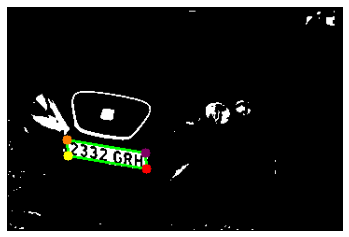

In [44]:
cv2.circle(frame_aux_array[rdn],(best_rect_array[rdn][0][0],best_rect_array[rdn][0][1]), 5, (255,128,0), -1)
cv2.circle(frame_aux_array[rdn],(best_rect_array[rdn][1][0],best_rect_array[rdn][1][1]), 5, (127,0,100), -1)
cv2.circle(frame_aux_array[rdn],(best_rect_array[rdn][2][0],best_rect_array[rdn][2][1]), 5, (255,0,0), -1)
cv2.circle(frame_aux_array[rdn],(best_rect_array[rdn][3][0],best_rect_array[rdn][3][1]), 5, (255,255,0), -1)

plt.imshow(frame_aux_array[rdn])
plt.xticks([]), plt.yticks([])
plt.show()

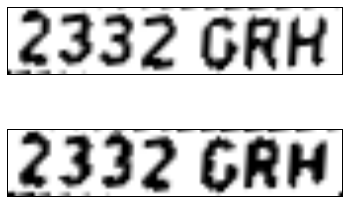

In [45]:
#We want our new image height to be newHeight pixels.
#Compute the ratio of the old height to the new height
newHeight = 200
# Initialize arrays of images
warp_lut_array = []
warp_gauss_array = []

for i in range(len(thresh_array)):
    orig_lut = thresh_array[i].copy()
    orig_gauss = thresgauss_array[i].copy()
    
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(best_widthA_array[i]), int(best_widthB_array[i]))
    maxHeight = max(int(best_heightA_array[i]), int(best_heightB_array[i]))
    
    # construct our destination points which will be used to
    # map the screen to a top-down view
    dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]], dtype = "float32")
    
    # calculate the perspective transform matrix and warp
    # the perspective to grab the screen
    M = cv2.getPerspectiveTransform(best_rect_array[i], dst)
    
    # Obtain the modified image with perspective corrected
    warp_lut_array.append(cv2.warpPerspective(orig_lut, M, (maxWidth, maxHeight)))
    warp_gauss_array.append(cv2.warpPerspective(orig_gauss, M, (maxWidth, maxHeight)))
    
plt.subplot(211),plt.imshow(warp_lut_array[rdn],'gray')
plt.xticks([]), plt.yticks([])
plt.subplot(212),plt.imshow(warp_gauss_array[rdn],'gray')
plt.xticks([]), plt.yticks([])
plt.show()


# Read text with pytesseract

write the grayscale image to disk as a temporary file so we can
apply OCR to it

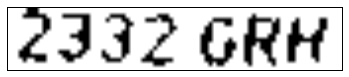

In [46]:
import uuid
umbral_array = []
filename_array = []

for i in range(len(warp_lut_array)):
    height = warp_lut_array[i].shape[0]
    width  = warp_lut_array[i].shape[1]
    crop_img = warp_lut_array[i][(int(height/15)):height, (int(width/90)):width]
    cerrar = cv2.dilate(crop_img, (5,5),4)
    ret,th = cv2.threshold(cerrar,150,255,cv2.THRESH_BINARY)
    umbral_array.append(th)
    # Generate random name to avoid overwriting
    unique_filename = str(uuid.uuid4())
    unique_filename = unique_filename+'.png'
    filename_array.append(unique_filename.format(os.getpid()))
    cv2.imwrite(filename_array[i], th)

plt.imshow(umbral_array[rdn],'gray')
plt.xticks([]), plt.yticks([])
plt.show()

Load image and apply OCR

In [47]:
matriculas = []
for i in range(len(filename_array)):
    matricula = pytesseract.image_to_string(Image.open(filename_array[i]))
    os.remove(filename_array[i])
    if matricula != '':
        matriculas.append(matricula)
    
print len(matriculas)
print len(filename_array)
print matriculas

53
470
[u'niui\ufb02', u'27:] cm', u'27:] cm', u'2312 um', u'2312 um', u'Z332 URN', u'Z332 URN', u'2332 GRN', u'2332 GRN', u'2332 CNN', u'2332 CNN', u'2332 CNN', u'2332 GEM', u'2332 um', u'2332 URN', u'2332 URN', u'2332 URN', u'2332 GEM', u'2332 GEM', u'2332 GRH', u'2332 CNN', u'2332 CNN', u'2332 GRHx', u'2332 GRH', u'Z332 GRH', u'Z332 GRH', u'2332 GRH\\', u'2332 GRH\\', u'2332 GRH', u'2332 GRH', u'2332 GRH', u'M', u'\u20182332 GRHw', u'\u20182332 GRHw', u'12332 GRH\u2018', u'\u2018 -n', u'\u2018 -n', u"' ,w/", u"' ,w/", u'2335\u20187372H', u'2335\u20187372H', u'2352 GRH\u2018', u'2352 GRH\u2018', u'233\ufb01\ufb01H', u'233???\u201c', u'233???\u201c', u"' \u2018\\\n\u2018\xae:.IQ \ufb02", u"' \u2018\\\n\u2018\xae:.IQ \ufb02", u"4'\u201c", u"4'\u201c", u'47', u'47', u'47']


Function to check wether s is a number or not

In [48]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def is_letter(l):
    return l.isalpha()
    

In [49]:
matricula_corregida_array = []

for plate in matriculas:
    # inicializar cada vez para que no se acumulen las medidas
    matricula_corregida = []
    for i in range(len(plate)-1,4,-1):
        if is_number(plate[i]) and not is_letter(plate[i]) or plate[i] == ' ':
            break
        elif is_letter(plate[i]):
            try: # lanza excepcion si hay caracteres por ahi que no son unicode
                matricula_corregida.insert(0,str(plate[i]))
            except:
                break


    for i in range(len(plate)-4,-1,-1):
        if is_number(plate[i]) and  not is_letter(plate[i]) and plate[i] != ' ':
            matricula_corregida.insert(0,str(plate[i]))
    if len(matricula_corregida) == 7:
        matricula_corregida_array.append(matricula_corregida)
        print matricula_corregida
        
    
print len(matricula_corregida_array)

['2', '3', '3', '2', 'G', 'R', 'N']
['2', '3', '3', '2', 'G', 'R', 'N']
['2', '3', '3', '2', 'C', 'N', 'N']
['2', '3', '3', '2', 'C', 'N', 'N']
['2', '3', '3', '2', 'C', 'N', 'N']
['2', '3', '3', '2', 'G', 'E', 'M']
['2', '3', '3', '2', 'U', 'R', 'N']
['2', '3', '3', '2', 'U', 'R', 'N']
['2', '3', '3', '2', 'U', 'R', 'N']
['2', '3', '3', '2', 'G', 'E', 'M']
['2', '3', '3', '2', 'G', 'E', 'M']
['2', '3', '3', '2', 'G', 'R', 'H']
['2', '3', '3', '2', 'C', 'N', 'N']
['2', '3', '3', '2', 'C', 'N', 'N']
['2', '3', '3', '2', 'G', 'R', 'H']
['2', '3', '3', '2', 'G', 'R', 'H']
['2', '3', '3', '2', 'G', 'R', 'H']
['2', '3', '3', '2', 'G', 'R', 'H']
['2', '3', '3', '2', 'G', 'R', 'H']
['2', '3', '3', '2', 'G', 'R', 'H']
['2', '3', '3', '5', '7', '3', 'H']
['2', '3', '3', '5', '7', '3', 'H']
['2', '3', '5', '2', 'G', 'R', 'H']
['2', '3', '5', '2', 'G', 'R', 'H']
24


In [50]:
from scipy import stats
m = stats.mode(matricula_corregida_array[1 :])
m

ModeResult(mode=array([['2', '3', '3', '2', 'G', 'R', 'H']], 
      dtype='|S1'), count=array([[23, 23, 21, 21, 13, 13, 11]]))